# U-NET

This notebook shows how to detect deadwood with U-Net, when the problem is *Semantic segmentation*.

First import, tell where the files are and make dataloaders.

In [1]:
from fastai.vision.all import *
import albumentations
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.tiling import *
from drone_detector.visualizations import *

def label_func(fn): return f'../data/analysis_data/rasterized_vector_tiles/{fn.stem}{fn.suffix}'


fnames = [Path(f'../data/analysis_data/raster_tiles/{f}') for f in 
          os.listdir('../data/analysis_data/rasterized_vector_tiles/')]

def get_train_aug(): return albumentations.Compose([
            albumentations.RandomResizedCrop(160,160),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

    
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    order = 2
    
    def __init__(self, train_aug): store_attr()
        
    def before_call(self, b, split_idx): 
        self.idx = split_idx
        
    def encodes(self, x):
        img, mask = x
        aug = self.train_aug(image=np.array(img), mask=np.array(mask))
        aug_img = aug['image']
        aug_mask = aug['mask']

        return PILImage.create(aug_img), PILMask.create(aug_mask)
    

In [2]:
item_tfms = SegmentationAlbumentationsTransform(get_train_aug())

deadwood = SegmentationDataLoaders.from_label_func('../data/analysis_data', bs=16,
                                                   fnames=fnames,
                                                   label_func=label_func,
                                                   item_tfms = item_tfms,
                                                   batch_tfms= [
                                                       Normalize.from_stats(*imagenet_stats),
                                                   ])

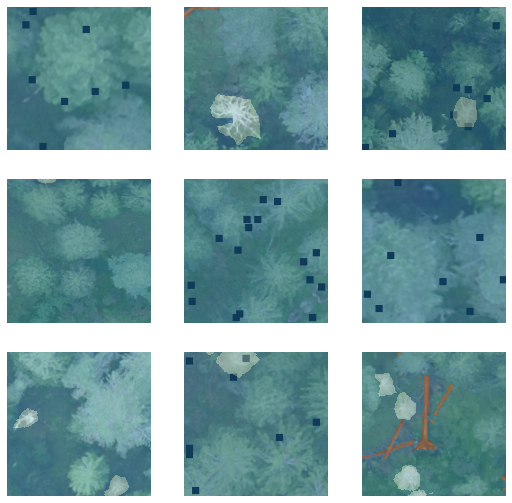

In [3]:
deadwood.show_batch()

In [4]:
class DiceMulti(Metric):
    "Averaged Dice metric (Macro F1) for multiclass target in segmentation"
    def __init__(self, axis=1): self.axis = axis
    def reset(self): self.inter,self.union = {},{}
    def accumulate(self, learn):
        pred,targ = flatten_check(learn.pred.argmax(dim=self.axis), learn.y)
        for c in range(learn.pred.shape[self.axis]):
            p = torch.where(pred == c, 1, 0)
            t = torch.where(targ == c, 1, 0)
            c_inter = (p*t).float().sum().item()
            c_union = (p+t).float().sum().item()
            if c in self.inter:
                self.inter[c] += c_inter
                self.union[c] += c_union
            else:
                self.inter[c] = c_inter
                self.union[c] = c_union

    @property
    def value(self):
        binary_dice_scores = np.array([])
        for c in self.inter:
            binary_dice_scores = np.append(binary_dice_scores, 2.*self.inter[c]/self.union[c] if self.union[c] > 0 else np.nan)
        return np.nanmean(binary_dice_scores)

Create a unet_learner with pretrained resnet50 as a backbone.

In [5]:
learn = unet_learner(deadwood, resnet101, pretrained=True, n_in=3, n_out=3, 
                     metrics=[foreground_acc, DiceMulti()]).to_fp16()

Due to memory issues, use mixed-precision training here.

Fine-tune for 3 freeze-epochs and 30 training epochs.

In [6]:
learn.fine_tune(10,freeze_epochs=1)

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,80.261024,0.156942,0.320891,0.505302,00:48


epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.144719,0.120913,0.381167,0.514123,00:30
1,0.132811,0.109551,0.489500,0.645989,00:29
2,0.128827,0.167706,0.569435,0.524835,00:29
3,0.125974,0.134790,0.485620,0.603870,00:29
4,0.116259,0.107759,0.429235,0.653437,00:30
5,0.109100,0.097186,0.527335,0.700186,00:29
6,0.101294,0.096266,0.473263,0.690986,00:29
7,0.098506,0.089773,0.571656,0.709503,00:29
8,0.094911,0.088330,0.600963,0.725769,00:29
9,0.090160,0.086563,0.569987,0.722954,00:29


Return to full-precision.

In [7]:
learn.to_fp32()

See results.

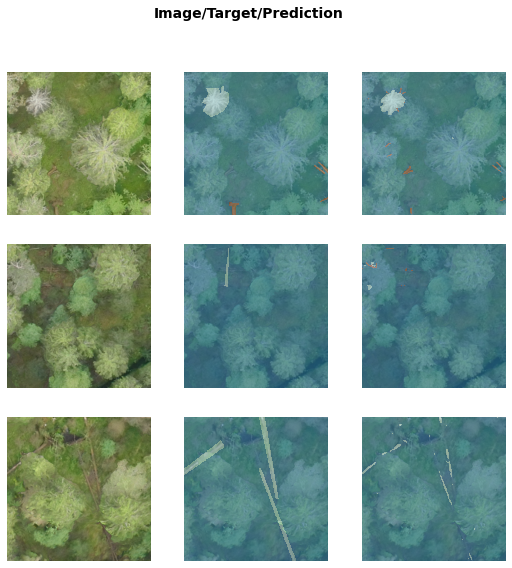

In [8]:
learn.show_results(max_n=9)

In [9]:
preds = learn.get_preds(with_input=True, with_decoded=True)

More informative way to see predictions.

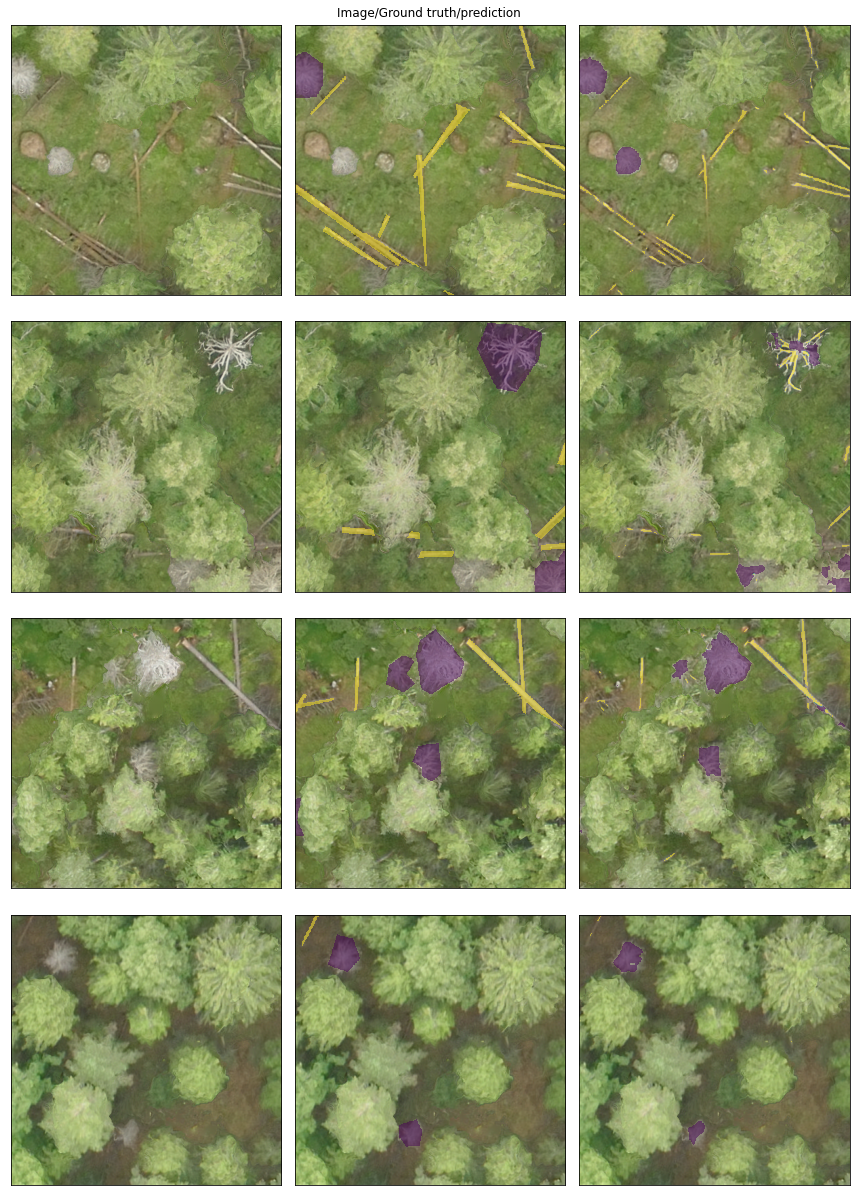

In [10]:
show_im_mask_pred(preds, max_n=4)

In [28]:
test_dl = learn.dls.test_dl(fnames)

In [29]:
preds = learn.get_preds(dl = test_dl)

<ipython-input-19-93aac88dcbfb>:24: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


In [30]:
fnames[0].stem

'R94C36'

In [31]:
import rasterio as rio

In [32]:
p = preds[0][1].numpy()

In [33]:
p.argmax(axis=0).shape

(400, 400)

In [34]:
fnames[1]

Path('../data/analysis_data/raster_tiles/R102C18.tif')

In [35]:
with rio.open(fnames[1]) as f:
    im = f.read()

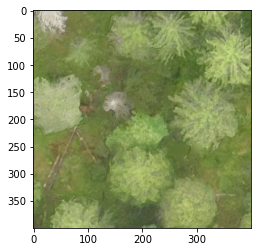

In [36]:
plt.imshow(im.swapaxes(0,2).swapaxes(0,1))

<AxesSubplot:>

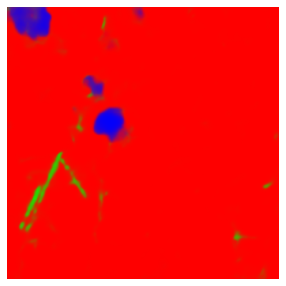

In [37]:
preds[0][1].show()

In [38]:
from osgeo import gdal

In [41]:
f.suffix

'.tif'

In [40]:
f.stem

'R84C32'

In [39]:
for f, p in zip(fnames[:10], preds[0][:10]):
    ds = gdal.Open(str(f))
    out_raster = gdal.GetDriverByName('gtiff').Create(f'../data/{f.stem}{f.suffix}',
                                                      ds.RasterXSize,
                                                      ds.RasterYSize,
                                                      1, gdal.GDT_Int16)
    out_raster.SetProjection(ds.GetProjectionRef())
    out_raster.SetGeoTransform(ds.GetGeoTransform())
    np_pred = p.numpy().argmax(axis=0)
    band = out_raster.GetRasterBand(1).WriteArray(np_pred)
    band = None
    out_raster = None
    ds = None

In [11]:
learn.export('album_unet_export.pkl')

In [4]:
learn = load_learner('../data/analysis_data/album_unet_export.pkl')

In [5]:
test_dl = learn.dls.test_dl(fnames)